**TESTING MY DATA AND FINDING ITS ACCURACY**

Firstly, I have just imported necessary libraries,my model and the detect_crop function from my previous colab notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from tensorflow.keras.models import load_model
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import shutil

model_path = '/content/drive/MyDrive/gender_detection_model.h5'

# Loading my model
model = load_model(model_path)

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Example: Replace username/dataset with the Kaggle dataset name
!kaggle datasets download -d yasserhessein/gender-dataset --unzip -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/yasserhessein/gender-dataset
License(s): unknown
100% 1.32G/1.32G [00:18<00:00, 50.9MB/s]
100% 1.32G/1.32G [00:18<00:00, 77.9MB/s]


In [18]:
def detect_and_crop_face(image_path, target_size=(150, 150)):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale

    # Detection of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:  # If faces are found
        # Cutting the first detected face
        x, y, w, h = faces[0]
        cropped_face = img[y:y+h, x:x+w]

        # Resizing the cropped face to the target size
        cropped_face_resized = cv2.resize(cropped_face, target_size)

        return cropped_face_resized
    else:
        return None

FUNCTION TO BE USED TO PREDICT AND ALSO TO SHOW THE GENDER USING A HEADER BOX

In [12]:
def detect_and_predict_gender(image_path, model, face_cascade):

    img = cv2.imread(image_path)
    # Again converting to grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Going through all the faces detected in the image
    for (x, y, w, h) in faces:
        # The below function draws a rectange around the selected face
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Cutting the face and resizing it
        face_img = img[y:y+h, x:x+w]
        face_img_resized = cv2.resize(face_img, (150, 150))
        face_img_resized = face_img_resized / 255.0

        # Predict gender using the model
        face_img_resized = np.expand_dims(face_img_resized, axis=0)  # Add batch dimension
        prediction = model.predict(face_img_resized)

        # Creating a prediction if condition in a form of a sigmoid function of classification
        gender = 'Female' if prediction[0] > 0.5 else 'Male'
        probability = (prediction[0]*100).item() if prediction[0] > 0.5 else ((1 - prediction[0])*100).item() # Probability of the predicted class

        # Changing the font size and thickness for our need
        font_scale = 0.5
        thickness = 2

        # Creating a label with the gender and probability
        label = f" {gender}, {probability:.2f}"
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

    # Convert the BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Displaying the image with box,gender and probability label
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()



Calling the function using a sample input randomly selected from our test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


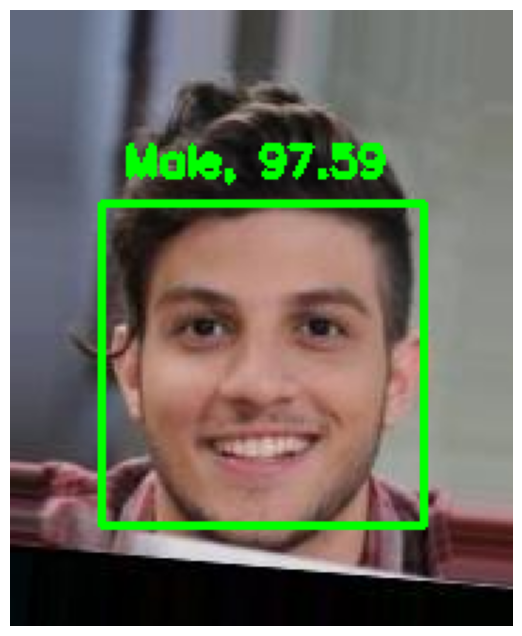

In [13]:
image_path = '/content/dataset/Dataset/Test/Male/160044.jpg' # Replace with your image path
detect_and_predict_gender(image_path, model, face_cascade)

Breaking the Test dataset onto a subfolder having 500 in each Male and Female so as to give labels and calculate accuracy on this sampled test dataset

In [19]:

def sample_test_data(test_dir, num_samples_per_class=500):


    test_faces = []
    test_labels = []

    for subfolder in os.listdir(test_dir):
        subfolder_path = os.path.join(test_dir, subfolder)

        if os.path.isdir(subfolder_path):
            label = 0 if subfolder == 'Male' else 1  # Male = 0, Female = 1

            # List all image files in the subfolder
            images = os.listdir(subfolder_path)

            # Randomly sample `num_samples_per_class` images
            sampled_images = random.sample(images, min(num_samples_per_class, len(images)))

            for img_name in sampled_images:
                img_path = os.path.join(subfolder_path, img_name)

                # Use the detect_and_crop_face function to preprocess the image
                cropped_face = detect_and_crop_face(img_path)  # Assuming detect_and_crop_face is implemented
                if cropped_face is not None:
                    test_faces.append(cropped_face)
                    test_labels.append(label)

    # Convert to NumPy arrays and normalize the images
    test_faces = np.array(test_faces)
    test_labels = np.array(test_labels)
    test_faces = test_faces / 255.0  # Normalize images to [0, 1]

    return test_faces, test_labels

In [20]:
def predict_genders(test_faces, model):

    predictions = model.predict(test_faces)  # Get probabilities
    predicted_labels = [1 if p > 0.5 else 0 for p in predictions]  # Convert probabilities to binary labels
    return predicted_labels

In [21]:
def calculate_accuracy(predicted_labels, test_labels):

    correct_predictions = np.sum(np.array(predicted_labels) == np.array(test_labels))
    accuracy = correct_predictions / len(test_labels)
    return accuracy

In [22]:
test_dir = '/content/dataset/Dataset/Test'
num_samples_per_class = 500

#  Step 1: Breaking the test data into a smaller sample
test_faces, test_labels = sample_test_data(test_dir, num_samples_per_class)

#  Predicting genders using our trained model
predicted_labels = predict_genders(test_faces, model)

#  Accuracy
accuracy = calculate_accuracy(predicted_labels, test_labels)
print(f"Model Accuracy on Sampled Test Data: {accuracy * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 509ms/step
Model Accuracy on Sampled Test Data: 90.94%
